Article: https://www.embedded-robotics.com/cnn-for-multi-label-text-classification/\
Code: Text Classification for20 Newsgroups dataset using CNN and GloVe Embeddings\
Prepared By: Awais Naeem (awais.naeem@embedded-robotics.com)\
Copyrights: www.embedded-robotics.com\
Disclaimer: This code can be distributed with the proper mention of the owner copyrights

In [1]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/awais.naeem@ebryx.com/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
newsgroup_train = fetch_20newsgroups(subset='train', shuffle=True)
newsgroup_test = fetch_20newsgroups(subset='test', shuffle=True)

In [4]:
print(newsgroup_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [5]:
df_train = pd.DataFrame({'article': newsgroup_train.data, 'label': newsgroup_train.target})
df_train.head()

,article,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [6]:
df_test = pd.DataFrame({'article': newsgroup_test.data, 'label': newsgroup_test.target})
df_test.head()

,article,label
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


### Exploratory Data Analysis

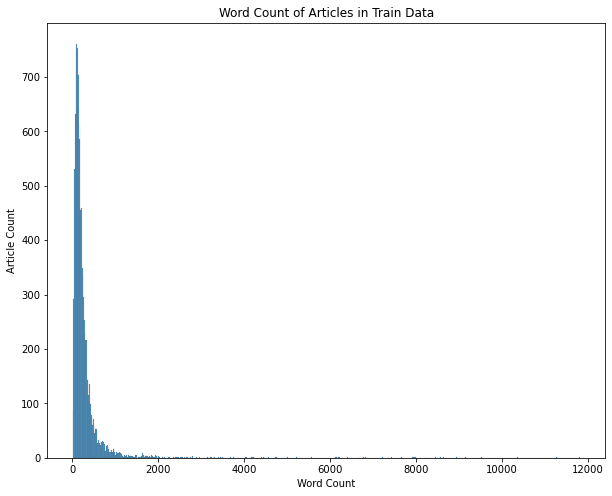

In [7]:
df_train['word_count'] = df_train['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count of Articles in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [8]:
train_articles = (sum(df_train['word_count'] < 1000)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 1000 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 1000 Words:96.80%


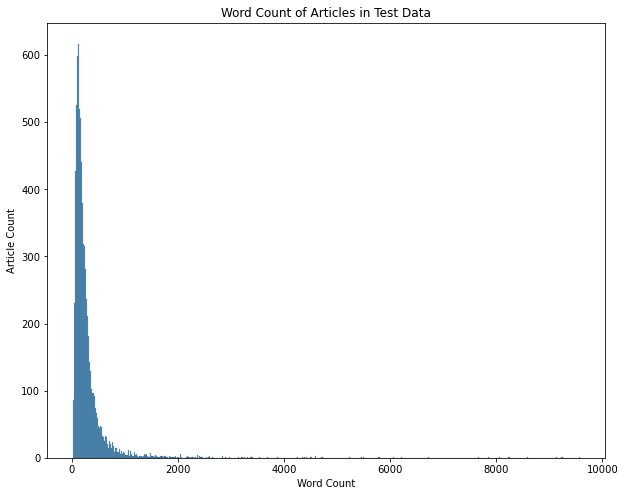

In [9]:
df_test['word_count'] = df_test['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count of Articles in Test Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [10]:
test_articles = (sum(df_test['word_count'] < 1000)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 1000 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 1000 Words:97.09%


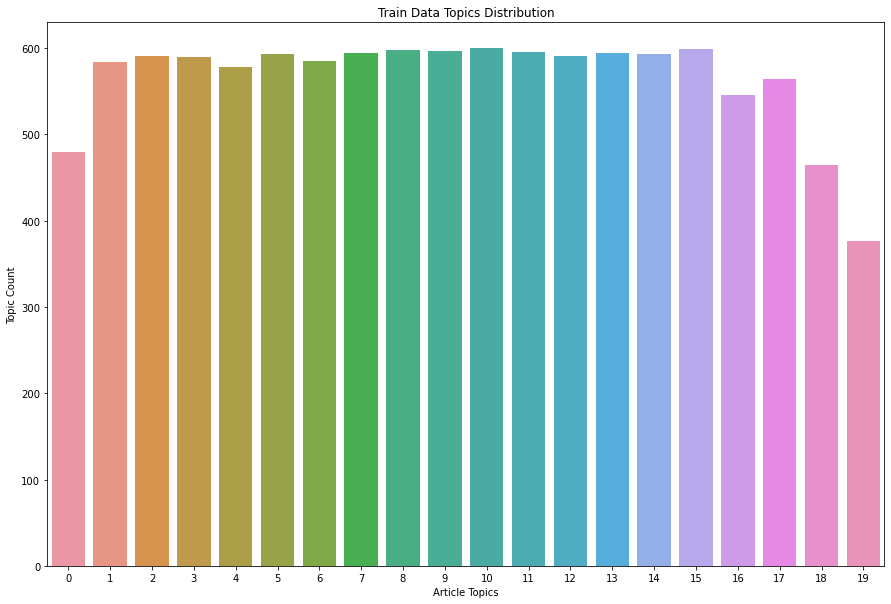

In [11]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_train, x='label')
plt.title('Train Data Topics Distribution')
plt.xlabel('Article Topics')
plt.ylabel('Topic Count')
plt.show()

### Data Cleaning and Pre-processing:
1. Remove pre and post spaces
2. Lower the case of tweet's text
3. Substitute new line chracter with spaces
4. Remove punctuation and special characters
5. Remove Stopwords
6. Word Lemmatization
7. Preparing feature space vectors

In [12]:
def get_wordnet_pos (tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
def lemmatize (word_list):
    wl = WordNetLemmatizer()
    word_pos_tags = pos_tag(word_list)
    lemmatized_list = []
    for tag in word_pos_tags:
        lemmatize_word = wl.lemmatize(tag[0],get_wordnet_pos(tag[1]))
        lemmatized_list.append(lemmatize_word)
    return " ".join(lemmatized_list)

In [14]:
def clean_text (text):
    # Remove Pre and Post Spaces
    text = str(text).strip()
    
    # Lower case the entire text
    text = str(text).lower()

    # Substitute New Line Characters with spaces 
    text = re.sub(r"\n", r" ", text)
        
    # Tokenize the sentence
    word_tokens = word_tokenize(text)
    
    # Remove the punctuation and  special characters from each individual word
    cleaned_text = []
    for word in word_tokens:
        cleaned_text.append("".join([char for char in word if char.isalnum()]))
    
    # Specify the stop words list
    stop_words = stopwords.words('english')
    
    # Remove the stopwords and words containing less then 2 characters
    text_tokens = [word for word in cleaned_text if (len(word) > 2) and (word not in stop_words)]
    
    #Lemmatize each word in the word list
    text = lemmatize (text_tokens)
    
    return text

In [15]:
df_train['article'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [16]:
clean_text (df_train['article'][0])

'lerxst wamumdedu thing subject car nntppostinghost rac3wamumdedu organization university maryland college park line wonder anyone could enlighten car saw day 2door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email thanks bring neighborhood lerxst'

In [17]:
df_train['article'] = df_train['article'].apply(lambda x: clean_text(x))

In [18]:
df_test['article'] = df_test['article'].apply(lambda x: clean_text(x))

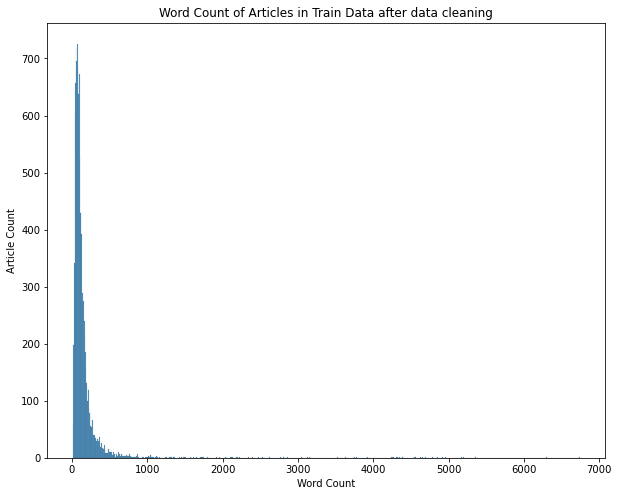

In [19]:
df_train['word_count'] = df_train['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count of Articles in Train Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [20]:
train_articles = (sum(df_train['word_count'] < 300)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 300 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 300 Words:92.05%


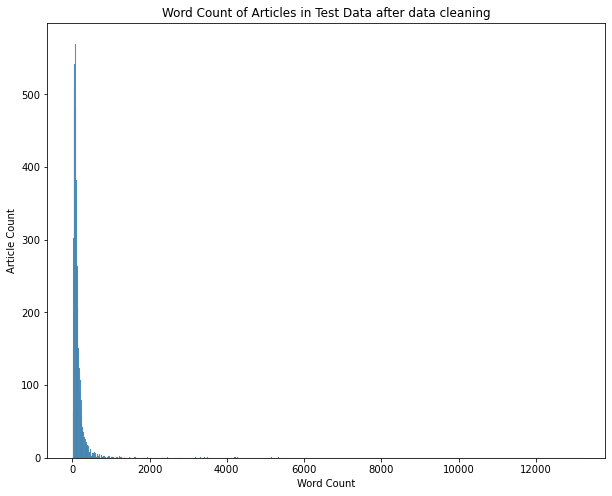

In [21]:
df_test['word_count'] = df_test['article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count of Articles in Test Data after data cleaning')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [22]:
test_articles = (sum(df_test['word_count'] < 300)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 300 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 300 Words:92.37%


In [23]:
X_train = df_train['article']
y_train = df_train['label']
X_test = df_test['article']
y_test = df_test['label']

In [24]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (11314,)
X_test: (7532,)
y_train: (11314,)
y_test: (7532,)


In [25]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

In [26]:
tokenizer.index_word

{1: 'line',
 2: 'subject',
 3: 'organization',
 4: 'would',
 5: 'one',
 6: 'write',
 7: 'use',
 8: 'get',
 9: 'say',
 10: 'article',
 11: 'know',
 12: 'people',
 13: 'like',
 14: 'make',
 15: 'think',
 16: 'university',
 17: 'time',
 18: 'nntppostinghost',
 19: 'max',
 20: 'well',
 21: 'good',
 22: 'also',
 23: 'see',
 24: 'new',
 25: 'work',
 26: 'system',
 27: 'could',
 28: 'take',
 29: 'year',
 30: 'want',
 31: 'go',
 32: 'right',
 33: 'need',
 34: 'come',
 35: 'even',
 36: 'thing',
 37: 'problem',
 38: 'way',
 39: 'may',
 40: 'look',
 41: 'give',
 42: 'god',
 43: 'file',
 44: 'find',
 45: 'many',
 46: 'state',
 47: 'first',
 48: 'two',
 49: 'much',
 50: 'question',
 51: 'distribution',
 52: 'try',
 53: 'call',
 54: 'point',
 55: 'program',
 56: 'run',
 57: 'world',
 58: 'anyone',
 59: 'post',
 60: 'drive',
 61: 'believe',
 62: 'tell',
 63: 'mean',
 64: 'seem',
 65: 'number',
 66: 'computer',
 67: 'help',
 68: 'please',
 69: 'something',
 70: 'window',
 71: 'really',
 72: 'include',

In [27]:
vocab_size = len(tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 148442


In [28]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [29]:
print("First Intance Text:\n")
print(X_train[0])
print("\nFirst Intance Total Words:", len(str(X_train[0]).split()))

First Intance Text:

lerxst wamumdedu thing subject car nntppostinghost rac3wamumdedu organization university maryland college park line wonder anyone could enlighten car saw day 2door sport car look late 60 early 70 call bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car make history whatever info funky look car please email thanks bring neighborhood lerxst

First Intance Total Words: 62


In [30]:
print("First Intance Text Sequence:\n")
print(X_train_token[0])
print("\nFirst Intance Text Sequence Length:", len(X_train_token[0]))

First Intance Text Sequence:

[26912, 4593, 36, 2, 97, 18, 18457, 3, 16, 2162, 441, 980, 1, 419, 58, 27, 5485, 97, 525, 76, 18458, 1043, 97, 40, 498, 9326, 531, 7189, 53, 26913, 899, 71, 248, 926, 640, 5283, 1127, 584, 414, 11, 58, 41656, 374, 106, 645, 1922, 29, 1952, 97, 14, 429, 618, 239, 18459, 40, 97, 68, 78, 90, 420, 4079, 26912]

First Intance Text Sequence Length: 62


In [31]:
print("Second Intance Text:\n")
print(X_train[1])
print("\nSecond Intance Total Words:", len(str(X_train[1]).split()))

Second Intance Text:

guykuo carsonuwashingtonedu guy kuo subject clock poll final call summary final call clock report keywords acceleration clock upgrade articleid shelley1qvfo9innc3s organization university washington line nntppostinghost carsonuwashingtonedu fair number brave soul upgrade clock oscillator share experience poll please send brief message detail experience procedure top speed attain cpu rat speed add card adapter heat sink hour usage per day floppy disk functionality 800 floppy especially request summarize next two day please add network knowledge base do clock upgrade answer poll thanks guy kuo guykuo uwashingtonedu

Second Intance Total Words: 84


In [32]:
print("Second Intance Text Sequence:\n")
print(X_train_token[1])
print("\nSecond Intance Text Sequence Length:", len(X_train_token[1]))

Second Intance Text Sequence:

[10702, 3064, 335, 7862, 2, 1006, 3096, 654, 53, 442, 654, 53, 1006, 237, 241, 3574, 1006, 988, 403, 62852, 3, 16, 536, 1, 18, 3064, 1260, 65, 1333, 1334, 988, 1006, 5984, 707, 326, 3096, 68, 123, 2079, 179, 544, 326, 1822, 464, 271, 7863, 1245, 2219, 271, 320, 122, 1839, 1619, 4196, 778, 2321, 546, 76, 911, 223, 3957, 1632, 911, 529, 494, 3922, 202, 48, 76, 68, 320, 351, 736, 172, 119, 1006, 988, 194, 3096, 90, 335, 7862, 10702, 4438]

Second Intance Text Sequence Length: 84


In [33]:
sequence_len = 300
X_train_token = pad_sequences(X_train_token, padding='post', maxlen=sequence_len)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=sequence_len)

In [34]:
print("First Intance Text Sequence:\n")
print(X_train_token[0])
print("\nFirst Intance Text Sequence Length:", len(X_train_token[0]))

First Intance Text Sequence:

[26912  4593    36     2    97    18 18457     3    16  2162   441   980
     1   419    58    27  5485    97   525    76 18458  1043    97    40
   498  9326   531  7189    53 26913   899    71   248   926   640  5283
  1127   584   414    11    58 41656   374   106   645  1922    29  1952
    97    14   429   618   239 18459    40    97    68    78    90   420
  4079 26912     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   

In [35]:
print("Second Intance Text Sequence:\n")
print(X_train_token[1])
print("\nSecond Intance Text Sequence Length:", len(X_train_token[1]))

Second Intance Text Sequence:

[10702  3064   335  7862     2  1006  3096   654    53   442   654    53
  1006   237   241  3574  1006   988   403 62852     3    16   536     1
    18  3064  1260    65  1333  1334   988  1006  5984   707   326  3096
    68   123  2079   179   544   326  1822   464   271  7863  1245  2219
   271   320   122  1839  1619  4196   778  2321   546    76   911   223
  3957  1632   911   529   494  3922   202    48    76    68   320   351
   736   172   119  1006   988   194  3096    90   335  7862 10702  4438
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

### Training Deep Neural Networks using pre-trained Glove Embeddings

In [36]:
home = os.path.expanduser('~')
glove_embedding_filepath = os.path.join(home, ".torch/datasets/glove_embeddings/glove.6B.100d.txt")

In [37]:
def create_embedding_matrix (filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as file:
        for line in file:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

In [38]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_embedding_filepath, tokenizer.word_index, embedding_dim)

In [39]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_len))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-06-25 12:34:22.568573: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-25 12:34:22.571446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 12:34:22.577635: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          14844200  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
Total params: 14,919,324
Trainable params: 14,919,324
Non-trainable params: 0
____________________________________________

In [40]:
history = model.fit(X_train_token, y_train, epochs=20, validation_data=(X_test_token, y_test), batch_size=128)

2022-06-25 12:34:23.275201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-25 12:34:23.300920: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


Epoch 1/20
89/89 [==============================] - 59s 630ms/step - loss: 2.9595 - accuracy: 0.1138 - val_loss: 2.3608 - val_accuracy: 0.3245
Epoch 2/20
89/89 [==============================] - 50s 565ms/step - loss: 1.5598 - accuracy: 0.5898 - val_loss: 0.9828 - val_accuracy: 0.7201
Epoch 3/20
89/89 [==============================] - 58s 653ms/step - loss: 0.2335 - accuracy: 0.9569 - val_loss: 0.8948 - val_accuracy: 0.7631
Epoch 4/20
89/89 [==============================] - 55s 614ms/step - loss: 0.0403 - accuracy: 0.9970 - val_loss: 0.9336 - val_accuracy: 0.7638
Epoch 5/20
89/89 [==============================] - 44s 490ms/step - loss: 0.0140 - accuracy: 0.9993 - val_loss: 0.9916 - val_accuracy: 0.7592
Epoch 6/20
89/89 [==============================] - 48s 534ms/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 1.0325 - val_accuracy: 0.7578
Epoch 7/20
89/89 [==============================] - 50s 560ms/step - loss: 0.0096 - accuracy: 0.9985 - val_loss: 1.0367 - val_accuracy: 0.7638

In [41]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  accuracy  val_loss  val_accuracy
0   2.846578  0.202051  2.360817      0.324482
1   1.140805  0.709829  0.982819      0.720127
2   0.203573  0.958900  0.894774      0.763144
3   0.036105  0.996641  0.933649      0.763808
4   0.014403  0.998763  0.991637      0.759161
5   0.009420  0.998851  1.032481      0.757833
6   0.009345  0.998586  1.036683      0.763808
7   0.005411  0.998939  1.054557      0.762878
8   0.004285  0.999205  1.074672      0.764604
9   0.004339  0.999293  1.101174      0.760489
10  0.002901  0.999381  1.152618      0.755311
11  0.003112  0.999381  1.139402      0.763409
12  0.003092  0.999381  1.154414      0.759692
13  0.002861  0.999381  1.221977      0.753585
14  0.001516  0.999646  1.186094      0.758364
15  0.002195  0.999470  1.233693      0.756240
16  0.001180  0.999646  1.204741      0.760754
17  0.001107  0.999823  1.271995      0.753850
18  0.001149  0.999646  1.247182      0.760489
19  0.000599  0.999823  1.223479      0.764737


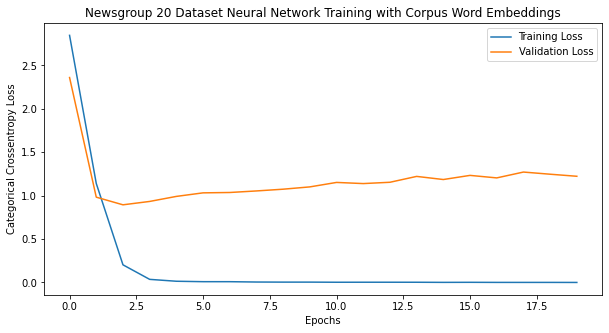

In [42]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Newsgroup 20 Dataset Neural Network Training with Corpus Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

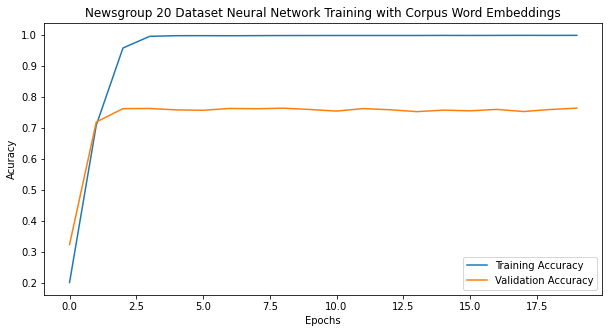

In [43]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Newsgroup 20 Dataset Neural Network Training with Corpus Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [44]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_len, weights = [embedding_matrix], trainable = True))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          14844200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                660       
Total params: 14,919,324
Trainable params: 14,919,324
Non-trainable params: 0
__________________________________________

In [45]:
history1 = model.fit(X_train_token, y_train, epochs=20, validation_data=(X_test_token, y_test), batch_size=128)

Epoch 1/20
89/89 [==============================] - 45s 487ms/step - loss: 2.7945 - accuracy: 0.1667 - val_loss: 1.8235 - val_accuracy: 0.4871
Epoch 2/20
89/89 [==============================] - 44s 490ms/step - loss: 1.3179 - accuracy: 0.6327 - val_loss: 1.1814 - val_accuracy: 0.6188
Epoch 3/20
89/89 [==============================] - 43s 486ms/step - loss: 0.6032 - accuracy: 0.8385 - val_loss: 1.0249 - val_accuracy: 0.6868
Epoch 4/20
89/89 [==============================] - 42s 478ms/step - loss: 0.2948 - accuracy: 0.9422 - val_loss: 0.9665 - val_accuracy: 0.7061
Epoch 5/20
89/89 [==============================] - 42s 476ms/step - loss: 0.1334 - accuracy: 0.9840 - val_loss: 1.0275 - val_accuracy: 0.7075
Epoch 6/20
89/89 [==============================] - 42s 471ms/step - loss: 0.0558 - accuracy: 0.9965 - val_loss: 1.0316 - val_accuracy: 0.7165
Epoch 7/20
89/89 [==============================] - 43s 480ms/step - loss: 0.0286 - accuracy: 0.9993 - val_loss: 1.0595 - val_accuracy: 0.7200

In [46]:
metrics_df = pd.DataFrame(history1.history)
print(metrics_df)

        loss  accuracy  val_loss  val_accuracy
0   2.485635  0.277709  1.823494      0.487122
1   1.134279  0.675800  1.181438      0.618826
2   0.565645  0.847888  1.024888      0.686803
3   0.279554  0.941135  0.966511      0.706054
4   0.126243  0.982500  1.027518      0.707515
5   0.054279  0.996111  1.031550      0.716543
6   0.026952  0.998851  1.059474      0.719995
7   0.017124  0.999028  1.087930      0.722385
8   0.012494  0.999205  1.104241      0.723447
9   0.009684  0.999293  1.149722      0.724774
10  0.008914  0.999028  1.131223      0.728226
11  0.006960  0.999205  1.196285      0.726766
12  0.007568  0.999293  1.232153      0.723181
13  0.006152  0.999470  1.228833      0.725836
14  0.006196  0.999381  1.236231      0.726102
15  0.006036  0.999381  1.227614      0.730749
16  0.007545  0.999205  1.273850      0.716277
17  0.004864  0.999470  1.381622      0.710170
18  0.006044  0.999293  1.287276      0.725571
19  0.005425  0.999558  1.249408      0.730350


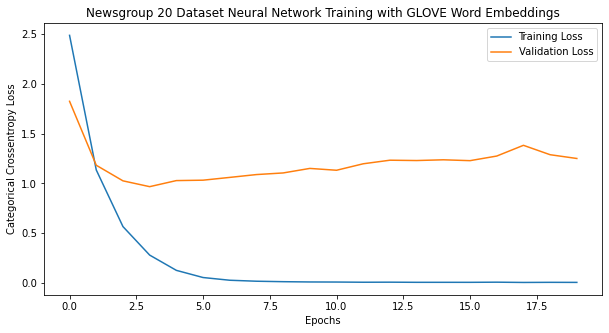

In [47]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Newsgroup 20 Dataset Neural Network Training with GLOVE Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

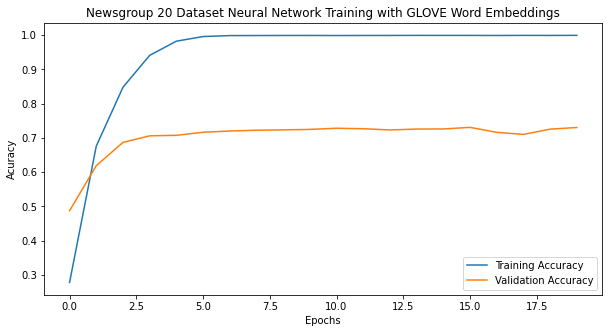

In [48]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('Newsgroup 20 Dataset Neural Network Training with GLOVE Word Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()